In [ ]:
!pip install pandas

  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl (11.5 MB)
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ------ --------------------------------- 2.1/12.6 MB 9.8 MB/s eta 0:00:02
   ---------- ----------------------------- 3.4/12.6 MB 8.4 MB/s eta 0:00:02
   --------------- ------------------------ 5.0/12.6 MB 7.7 MB/s eta 0:00:01
   ------------------- -------------------- 6.0/12.6 MB 7.1 MB/s eta 0:00:01
   ----------------------- ---------------- 7.3/12.6 MB 7.0 MB/s eta 0:00:01
   ---------------------------- ----------- 8.9/12.6 MB 6.9 MB/s eta 0:00:01
   --------------------------------- ------ 10.5/12.6 MB 7.0 MB/s eta 0:00:01
   ------------------------------------- -- 11.8/12.6 MB 7.0 MB/s eta 0:00:01
   ---------------------------------------- 12.6/12.6 MB 6.8 MB/s eta 0:00:00

   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0

##  Klassifikation der Phagen-Gene in zeitliche Expressionsphasen

In diesem Schritt werden alle verfügbaren Phagen-RNAseq-Dateien verarbeitet, um jedem Gen ein zeitliches Expressionslabel (`early`, `middle`, `late`, `unknown`) zuzuordnen.  
Das Label basiert auf der mittleren Expression über unterschiedliche Zeitpunkte hinweg.

Je nach Anzahl der Zeitpunkte erfolgt die Aufteilung wie folgt:

- **≥ 3 Zeitpunkte**: automatische Einteilung in early / middle / late (je ein Drittel)
- **2 Zeitpunkte**: nur `early` und `late`
- **1 Zeitpunkt**: keine Einordnung möglich → `unknown`

Ziel: Trainings- und Testdaten mit eindeutig gelabelten Genen für maschinelles Lernen oder vergleichende Genexpressionsanalysen.

In [28]:
import pandas as pd
import os
import glob
import re

# Hauptklassifikationsfunktion mit Fallback-Strategie
def classify_expression_with_fallback(file_path):
    df = pd.read_csv(file_path, sep='\t')

    # 1. Zeitspalten erkennen (z. B. 10_R1 oder 10)
    timepoint_cols = {}
    for col in df.columns:
        match_r = re.match(r'^(\d+\.?\d*)_R\d+$', col)
        match_simple = re.match(r'^(\d+\.?\d*)$', col)
        if match_r:
            time = float(match_r.group(1))
            timepoint_cols.setdefault(time, []).append(col)
        elif match_simple:
            time = float(match_simple.group(1))
            timepoint_cols.setdefault(time, []).append(col)

    sorted_times = sorted(timepoint_cols.keys())
    n = len(sorted_times)

    if n == 0:
        raise ValueError("Keine gültigen Zeitpunkte gefunden.")
    
    elif n == 1:
        # Nur ein Zeitpunkt → kein Vergleich möglich
        df['Label'] = 'unknown'

    elif n == 2:
        # Zwei Zeitpunkte → early und late
        early, late = sorted_times
        early_cols = timepoint_cols[early]
        late_cols = timepoint_cols[late]

        df['mean_early'] = df[early_cols].mean(axis=1)
        df['mean_late'] = df[late_cols].mean(axis=1)

        df['Label'] = df[['mean_early', 'mean_late']].idxmax(axis=1).str.replace('mean_', '')

    else:
        # Drei oder mehr Zeitpunkte → early, middle, late
        early = sorted_times[:n // 3]
        middle = sorted_times[n // 3:2 * n // 3]
        late = sorted_times[2 * n // 3:]

        early_cols = [col for t in early for col in timepoint_cols[t]]
        middle_cols = [col for t in middle for col in timepoint_cols[t]]
        late_cols = [col for t in late for col in timepoint_cols[t]]

        df['mean_early'] = df[early_cols].mean(axis=1)
        df['mean_middle'] = df[middle_cols].mean(axis=1)
        df['mean_late'] = df[late_cols].mean(axis=1)

        df['Label'] = df[['mean_early', 'mean_middle', 'mean_late']].idxmax(axis=1).str.replace('mean_', '')

    return df[['Geneid', 'Entity', 'Symbol', 'Label']]

# Verarbeite alle Dateien rekursiv im ../data-Verzeichnis
tsv_files = glob.glob("../data/**/*full_raw_counts.tsv", recursive=True)
all_results = []

for file in tsv_files:
    print(f"Verarbeite Datei: {os.path.basename(file)}")
    try:
        result = classify_expression_with_fallback(file)
        result['SourceFile'] = os.path.basename(file)
        all_results.append(result)
    except Exception as e:
        print(f"Fehler bei Datei {file}: {e}")

# Zusammenführen und anzeigen
if all_results:
    final_df = pd.concat(all_results, ignore_index=True)
    #print(f"Gesamtanzahl Gene mit Label: {len(final_df)}")
    #print("Gene pro Datei:")
    #print(final_df['SourceFile'].value_counts())
    
    display(final_df.head(20))  # Zeige die ersten 20 Einträge
    # Optional: Speichern
    # final_df.to_csv("../data/gene_labels_all_files.csv", index=False)
else:
    print("Keine gültigen Dateien verarbeitet.")


# 1. Anzahl Gene pro Label global
print("\nAnzahl Gene je Label (gesamt):")
print(final_df['Label'].value_counts())

# 2. Anzahl Gene pro Label je Datei
print("\n Verteilung je Datei:")
label_counts_per_file = final_df.groupby(['SourceFile', 'Label']).size().unstack(fill_value=0)
display(label_counts_per_file)


Verarbeite Datei: Brandao_LB_full_raw_counts.tsv
Verarbeite Datei: Brandao_MCCM_full_raw_counts.tsv
Verarbeite Datei: Ceyssens_directional_full_raw_counts.tsv
Verarbeite Datei: Ceyssens_non-directional_full_raw_counts.tsv
Verarbeite Datei: Finstrlova_Newman_full_raw_counts.tsv
Verarbeite Datei: Finstrlova_SH1000_full_raw_counts.tsv
Verarbeite Datei: Guegler_T4_minusToxIN_full_raw_counts.tsv
Verarbeite Datei: Guegler_T4_plusToxIN_full_raw_counts.tsv
Verarbeite Datei: Guegler_T7_minusToxIN_full_raw_counts.tsv
Verarbeite Datei: Guegler_T7_plusToxIN_full_raw_counts.tsv
Verarbeite Datei: Kuptsov_full_raw_counts.tsv
Verarbeite Datei: Leskinen_full_raw_counts.tsv
Verarbeite Datei: Li_full_raw_counts.tsv
Verarbeite Datei: Lood_full_raw_counts.tsv
Verarbeite Datei: Meaden_BIM_full_raw_counts.tsv
Fehler bei Datei ../data\meaden_2021\Meaden_BIM_full_raw_counts.tsv: Keine gültigen Zeitpunkte gefunden.
Verarbeite Datei: Meaden_WT_full_raw_counts.tsv
Fehler bei Datei ../data\meaden_2021\Meaden_WT_fu

,Geneid,Entity,Symbol,Label,SourceFile
0,gene-PA2589,host,gene-PA2589,middle,Brandao_LB_full_raw_counts.tsv
1,gene-PA1795,host,cysS,early,Brandao_LB_full_raw_counts.tsv
2,gene-PA2468,host,foxI,early,Brandao_LB_full_raw_counts.tsv
3,gene-PA4119,host,aph,middle,Brandao_LB_full_raw_counts.tsv
4,gene-PA2246,host,bkdR,middle,Brandao_LB_full_raw_counts.tsv
5,gene-PA1033,host,gene-PA1033,middle,Brandao_LB_full_raw_counts.tsv
6,gene-PA2214,host,gene-PA2214,middle,Brandao_LB_full_raw_counts.tsv
7,gene-PA3210,host,trkH,middle,Brandao_LB_full_raw_counts.tsv
8,gene-PA4724,host,gene-PA4724,middle,Brandao_LB_full_raw_counts.tsv
9,gene-PA5368,host,pstC,early,Brandao_LB_full_raw_counts.tsv



Anzahl Gene je Label (gesamt):
Label
early     56638
middle    20982
late      12883
Name: count, dtype: int64

 Verteilung je Datei:


Label,early,late,middle
SourceFile,,,
Brandao_LB_full_raw_counts.tsv,1189,484,4046
Brandao_MCCM_full_raw_counts.tsv,3952,57,1710
Ceyssens_directional_full_raw_counts.tsv,5177,368,496
Ceyssens_non-directional_full_raw_counts.tsv,4937,676,428
Finstrlova_Newman_full_raw_counts.tsv,2546,211,333
Finstrlova_SH1000_full_raw_counts.tsv,2039,137,645
Guegler_T4_minusToxIN_full_raw_counts.tsv,3491,119,1162
Guegler_T4_plusToxIN_full_raw_counts.tsv,3766,783,223
Guegler_T7_minusToxIN_full_raw_counts.tsv,3965,125,454


In [29]:
!pip install matplotlib seaborn

<Figure size 1200x600 with 0 Axes>

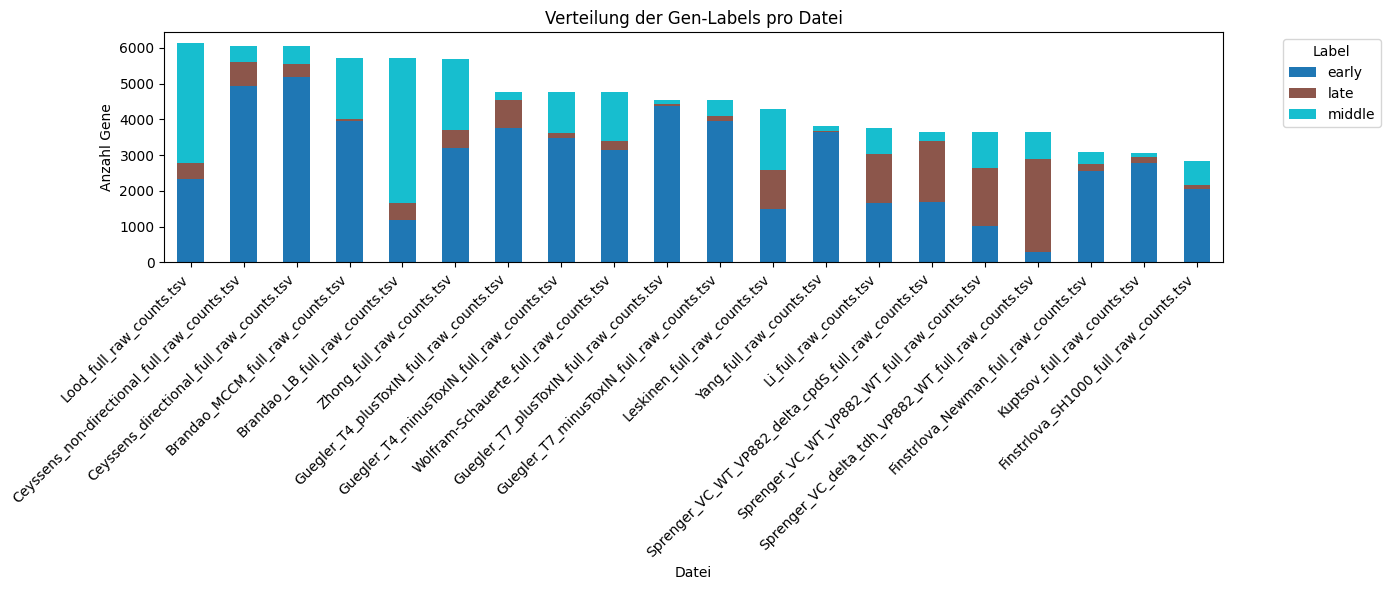

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gruppiere Labels je Datei
label_counts = final_df.groupby(['SourceFile', 'Label']).size().unstack(fill_value=0)

# Sortiere nach Gesamtzahl (optional)
label_counts = label_counts.loc[label_counts.sum(axis=1).sort_values(ascending=False).index]

# Plot-Einstellungen
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', stacked=True, colormap='tab10', figsize=(14, 6))

plt.title("Verteilung der Gen-Labels pro Datei")
plt.xlabel("Datei")
plt.ylabel("Anzahl Gene")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Anzeigen
plt.show()

# Optional: Speichern
# plt.savefig("../data/gene_label_distribution.png", dpi=300)
